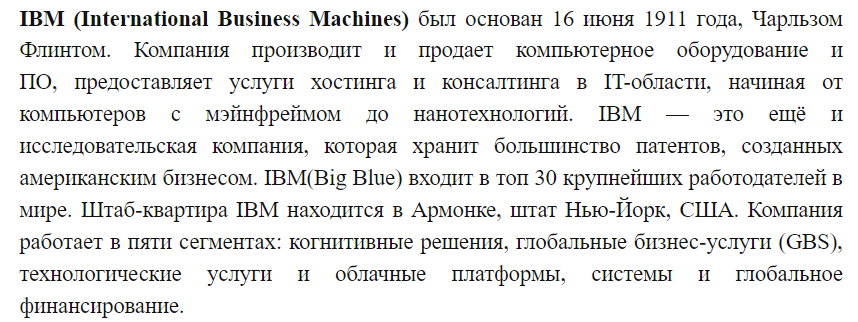

In [86]:
import pandas as pd 
import numpy as np
import yfinance as yf
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Часть 1. Расчёт будущей доходности акций IBM на основе модели CAPM

Для расчета были взяты ежедневные котировки акции International Business Machines Corporation (IBM) и индекса S&P 500 (^GSPC) за период с 01.01.2021 по 01.01.2022 г.

In [62]:
# получим данные: 
stock = yf.download('IBM','2021-01-01','2022-01-01')["Close"].values
index = yf.download('^GSPC','2021-01-01','2022-01-01')["Close"].values

# преобразуем в один массив: 
data = np.array([stock, index])

# и создадим таблицу значений доходности по дням в течение года: 
df = pd.DataFrame(data.T).apply(lambda x: ((x.shift(-1)-x)/x)[:-1].values)
df.columns = ['IBM', 'S&P 500']
df.head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,IBM,S&P 500
0,0.017751,0.007083
1,0.024972,0.005710
2,-0.002320,0.014847
3,-0.003566,0.005492
4,0.000389,-0.006555


In [34]:
df.isna().sum()

IBM        0
S&P 500    0
dtype: int64

In [33]:
V = df.cov() * 10_000   
mu = df.mean(axis=0)    
print('ковариационная матрица:\n', V, '\n\n ожидаемая доходность: \n',  mu)

ковариационная матрица:
               IBM   S&P 500
IBM      2.131366  0.346714
S&P 500  0.346714  0.673784 

 ожидаемая доходность: 
 IBM        0.000589
S&P 500    0.001042
dtype: float64


Text(0.5, 1.0, 'доходность индекса S&P 500')

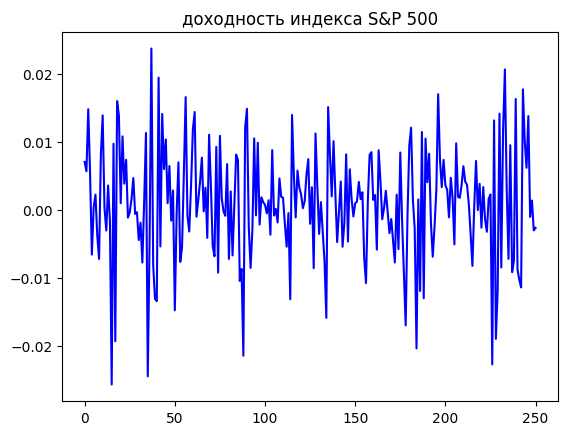

In [97]:
plt.plot(df['S&P 500'], color = 'b')
plt.title('доходность индекса S&P 500')

Text(0.5, 1.0, 'доходность акций IBM')

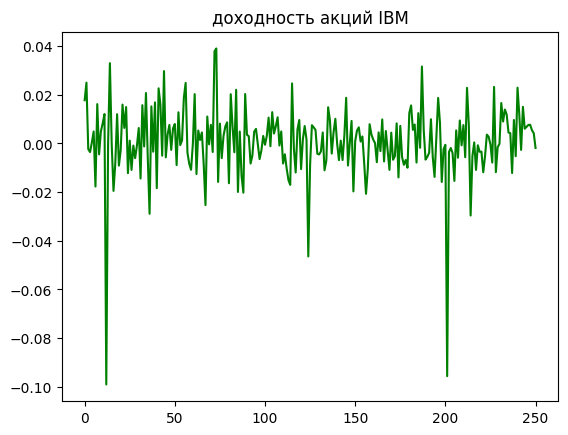

In [98]:
plt.plot(df['IBM'], color = 'g')
plt.title('доходность акций IBM')

y - акция, x - индекс 

In [119]:
model = LinearRegression()

x = (df['S&P 500'].values).reshape(-1,1)
y =  df['S&P 500'].values
model.fit(x, y)

beta = model.intercept_
print('R^2 = ', model.score(x, y)) # отличное качество модели
print('b0 (бета-коэффициент) = ', beta) 

R^2 =  1.0
b0 (бета-коэффициент) =  -2.168404344971009e-19


В настоящее время существует несколько способов, применяемых для оценки
безрисковой процентной ставки. А именно, на основе

1. Доходности по государственным ценным бумагам (min 3,5 % 10 летние цб)
2. Ключевой ставки ФРС (0,25 %) 
3.  Процентной ставки по межбанковским кредитам (3,25%)

In [122]:
mu_f = 0.25
mu_m = df['S&P 500'].mean()
mu_carm_ibm = mu_f + beta * (mu_m - mu_f)

print('безрисковая ставка = ', mu_f)
print('доходность рынка = ', round(mu_m,5))
print('доходность IBM = ', mu_carm_ibm)

безрисковая ставка =  0.25
доходность рынка =  0.00104
доходность IBM =  0.25


Видим, что по модели CARM ожидается доходность акций IBM в размере 0,5%, что совпадает с доходностью по безрисковому активу. Доходность
рынка практически нулевая (0,00104%). Это объясняется тем, что наблюдался
кризис на фондовом рынке, что привело к оттоку капитала и созданию
неустойчивой инвестиционной среде на фоне эпидемии и мировой обстановки (2021-2022 год) 

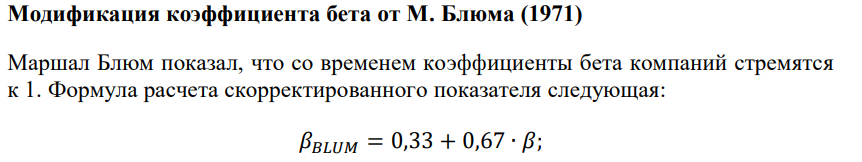

In [123]:
beta_blum = 0.33 + 0.67*beta
beta_blum

0.33

# Часть 2. Моделирование поведения акции методом Монте-Карло

In [229]:
ibm = yf.download('IBM','2021-01-01','2022-01-01')
ibm.head(3)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,120.315491,120.382408,117.629066,118.489487,106.178665,5417443
2021-01-05,119.512428,121.108986,119.130020,120.592735,108.063393,6395872
2021-01-06,121.319313,126.080307,121.147224,123.604210,110.761986,8322708


In [158]:
daily_returns = ibm['Adj Close'].pct_change()
daily_volatility = daily_returns.std()

In [202]:
trading_days = 252
simulations =  10  # различных траекторий 
last_price = ibm['Adj Close'][-1]

df_track = pd.DataFrame()  # df для цен в каждой траектории
last_price_list = []


for s in range(0, simulations, 1):
    price_list = []
    price = last_price * (1 + np.random.normal(0, daily_volatility))
    price_list.append(price)
    
    for day in range(0, trading_days, 1):
        price = price_list[day]* (1 + np.random.normal(0, daily_volatility))
        price_list.append(price)
    
    df_track[s] = price_list
    last_price_list.append(price_list[-1])

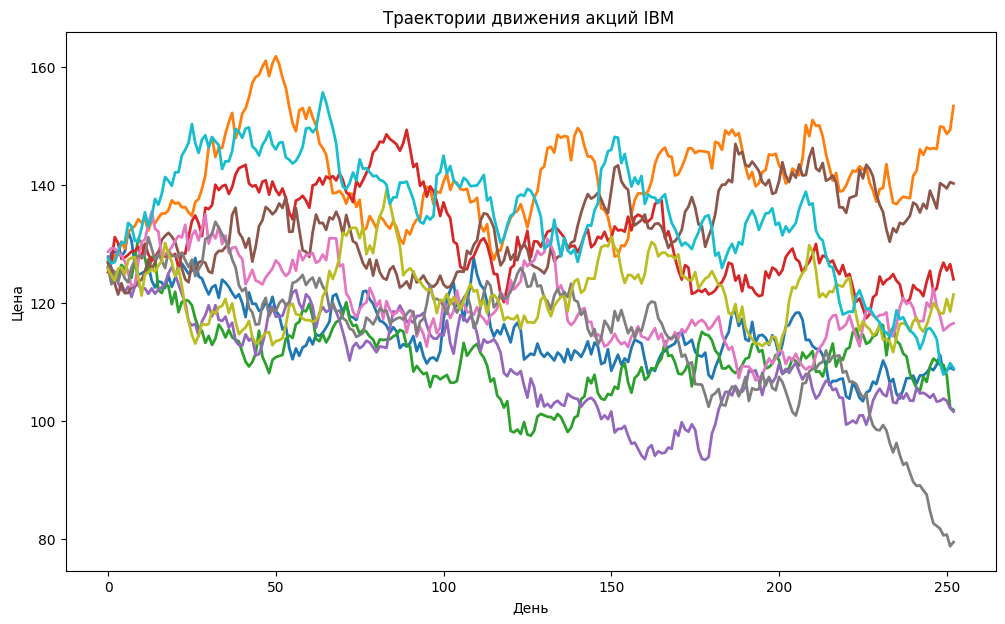

In [207]:
fig, ax = plt.subplots(figsize = (12, 7))
plt.title('Траектории движения акций IBM ')
ax.plot(df_track, linewidth=2)
plt.xlabel('День')
plt.ylabel('Цена')
plt.show()

In [208]:
df_track

,0,1,2,3,4,5,6,7,8,9
0,125.916508,127.093013,126.844867,125.213848,127.860490,126.755819,128.681443,126.135424,125.739984,127.557755
1,128.522429,126.682882,125.208348,126.931961,125.765096,125.922862,129.291628,123.167643,124.669296,126.707994
2,128.621267,128.100927,123.795033,131.161651,125.229197,123.269773,129.221064,125.266442,123.791142,126.928800
3,128.608254,128.197473,124.215825,130.139674,123.382645,121.434541,128.669218,123.572997,125.797755,128.626255
4,127.994061,130.424873,126.462536,127.481146,122.249605,123.350016,128.016737,125.691803,126.019896,130.291157
...,...,...,...,...,...,...,...,...,...,...
248,111.181569,149.910253,109.482498,125.255450,103.416918,140.307076,117.754108,81.748925,118.298807,109.833116
249,108.134806,149.784579,109.525818,126.841277,103.805566,139.918080,115.336865,80.615122,118.215998,107.891862
250,108.644350,148.652422,107.664923,125.496764,103.426166,139.426235,115.825929,80.753798,120.684517,108.420999
251,109.019110,149.330246,102.252571,126.581934,102.191555,140.481645,116.308703,78.780198,118.563455,109.789317


In [228]:
print('цена акции IBM по прогнозу изменяется от', round(min(last_price_list),4),
      'до', round(max(last_price_list), 4),'$')

цена акции IBM по прогнозу изменяется от 79.487 до 153.3679 $


In [231]:
last_price

125.79918670654297

Моделирование траекторий позволяет заметить, что акции IBM могут как упасть в цене, так и вырасти.